In [51]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

def show_10_images(data):    
    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(data[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        
        ax.get_yaxis().set_visible(False)
    plt.show()

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1666666, random_state=42)

x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_val = np.reshape(x_val, (len(x_val), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))


print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(50000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)


In [52]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from keras.regularizers import l1
from keras.models import Model

def create_model(i, n_hidden):
    input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(2, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # at this point the representation is (7, 7, 32)

    x = Flatten()(x)
    encoded = Dense(n_hidden, activity_regularizer=l1(10e-8))(x)

    # representation is now size n_hidden

    x = Dense(7*7*32)(encoded)
    x = Reshape((7, 7, 32))(x)

    x = Conv2D(2, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    
    # Change layer names to prevent weight sharing
    for i, layer in enumerate(autoencoder.layers):
        layer.name = 'layer'+str(i)+'_model'
        
    return autoencoder, encoder

Training autoencoder 0


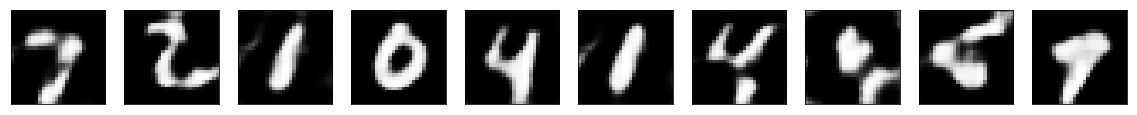

Training autoencoder 1


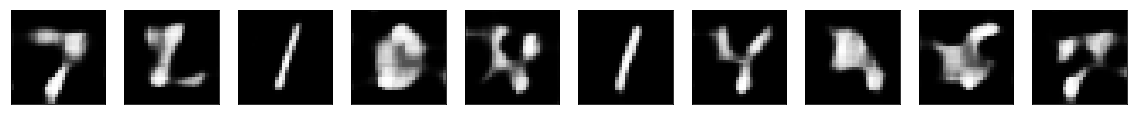

Training autoencoder 2


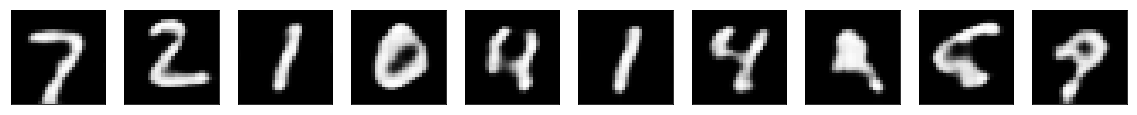

Training autoencoder 3


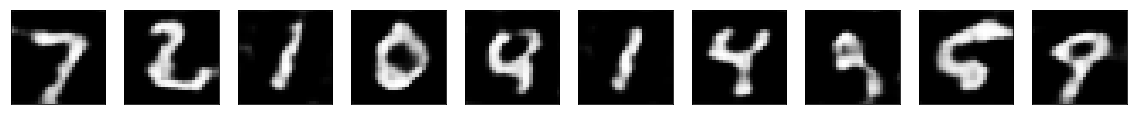

Training autoencoder 4


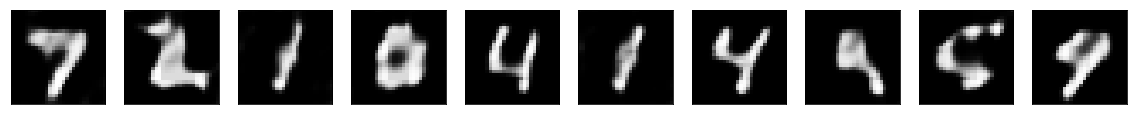

Training autoencoder 5


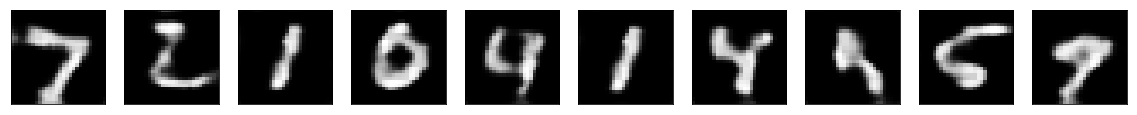

Training autoencoder 6


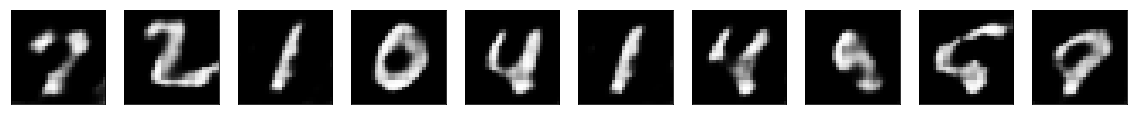

Training autoencoder 7


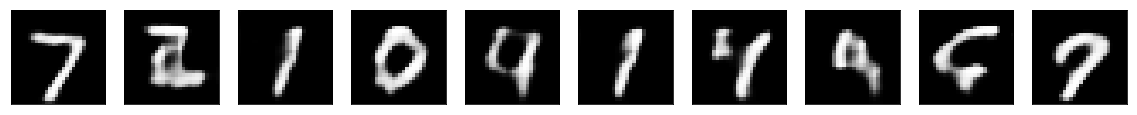

Training autoencoder 8


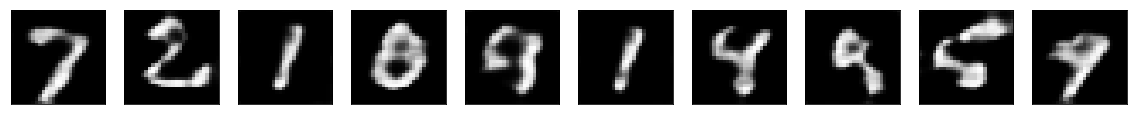

Training autoencoder 9


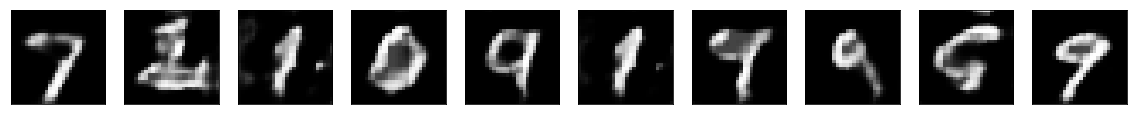

In [53]:
import os, gc
models = [create_model(i, n_hidden) for i in range(10)]
autoencoders = [m[0] for m in models]
encoders = [m[1] for m in models]

for i in range(10):
    print("Training autoencoder", i)
    autoencoders[i].compile(optimizer='adadelta', loss='binary_crossentropy')
    
    f = y_train == i
    x_train_filtered = x_train[f]
    
    f = y_test == i
    x_test_filtered = x_test[f]

#     weight_file = './weights/mnist_autoencoder_digit_%d_binary_crossentropy_%dh.hd5' % (i, n_hidden)
    weight_file = './weights/mnist_autoencoder_digit_%d_binary_crossentropy_valsplit_%dh.hd5' % (i, n_hidden)
    if(os.path.exists(weight_file)):
        autoencoders[i].load_weights(weight_file)
    else:
        autoencoders[i].fit(x_train_filtered, x_train_filtered,
                        epochs=50,
                        batch_size=256,
                        shuffle=True,
                        validation_data=(x_test_filtered, x_test_filtered),
                        callbacks=[])
        autoencoders[i].save_weights(weight_file)
    
    show_10_images(autoencoders[i].predict(x_test))    

In [54]:
from keras.layers import Lambda
from keras.losses import binary_crossentropy
import keras.backend as K 

input_ = Input(shape=(28, 28, 1))
predictions = [l(input_) for l in autoencoders]
losses = [
    Lambda(lambda x: binary_crossentropy(
        K.batch_flatten(input_), 
        K.batch_flatten(x))
    )(p) for p in predictions]

# min_loss = Lambda(lambda a: K.min(a))(losses)

# anomaly_detector = Model(input_, min_loss)
anomaly_detector = Model(input_, losses)

In [55]:
predictions = anomaly_detector.predict(x_test)

In [56]:
# Add Bayesian-and-novelty directory to the PYTHONPATH
import sys
import os
sys.path.append(os.path.realpath('../../../..'))

# Autoreload changes in utils, etc.
%load_ext autoreload
%autoreload 2

from novelty.utils.metrics import plot_roc, plot_prc, barcode_plot
from novelty.utils.metrics import get_summary_statistics
from novelty.utils.metrics import html_summary_table

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0
roc 0.9379702135843251


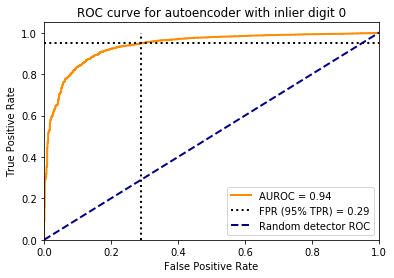

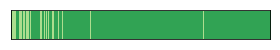

1
roc 0.9981213056344432


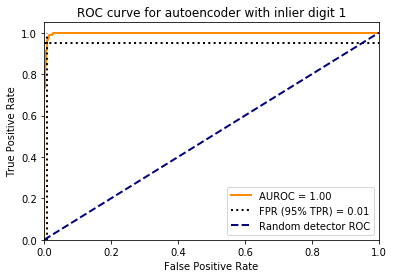

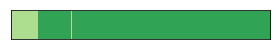

2
roc 0.6793937661210575


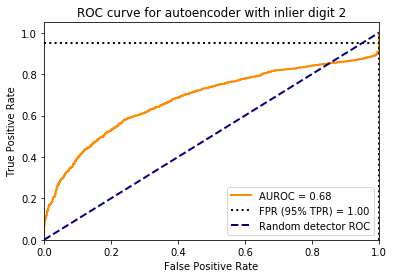

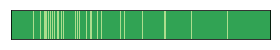

3
roc 0.6788547781363231


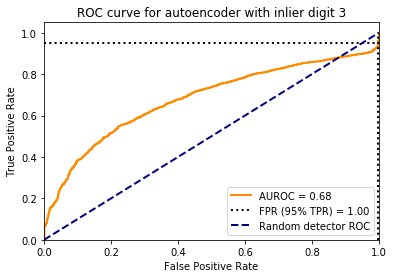

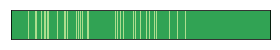

4
roc 0.84103720596824


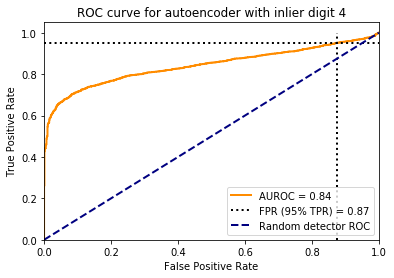

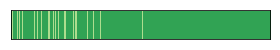

5
roc 0.7262981860917619


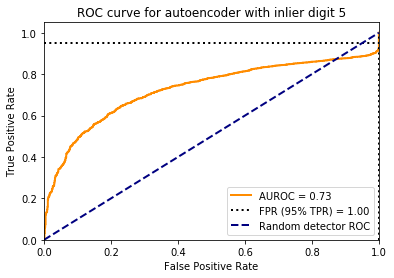

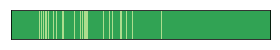

6
roc 0.7981362433440974


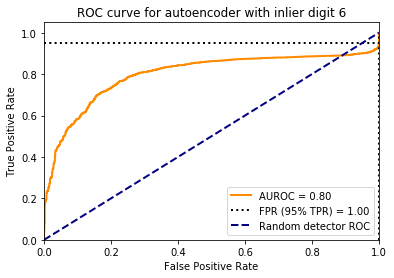

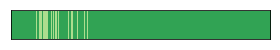

7
roc 0.9339218554569251


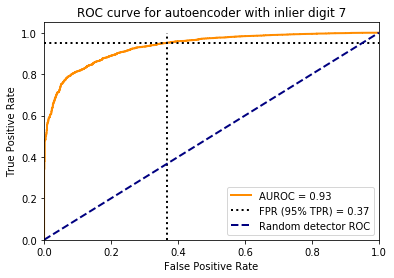

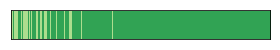

8
roc 0.5505104236858975


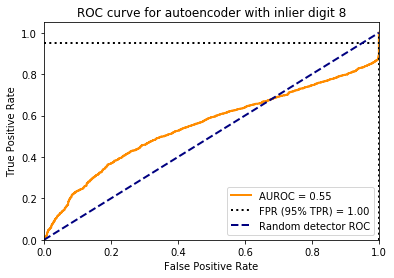

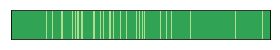

9
roc 0.8595703951942252


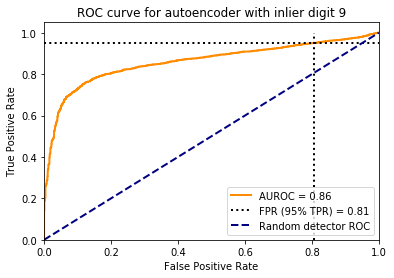

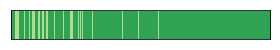

In [57]:
from sklearn.metrics import roc_auc_score

labels = [y_test != i for i in range(10)]

for i in range(10):
    print(i)
    print("roc", roc_auc_score(labels[i], predictions[i]))
    plot_roc(predictions[i], labels[i], title="ROC curve for autoencoder with inlier digit %d" % i)
    barcode_plot(predictions[i], labels[i])    

In [58]:
digit = 0
zeros = np.array([(score, index) for index, score in enumerate(predictions[digit])])
not_zeros = zeros[labels[digit]]
zeros = zeros[[not a for a in labels[digit]]]

Most anomalous inlier
0.25368812680244446
label 0


/home/tadenoud/.virtualenvs/ml/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':


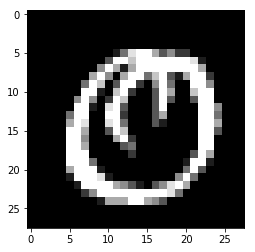

Least anomalous outlier
0.07151395827531815
label 1


/home/tadenoud/.virtualenvs/ml/local/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


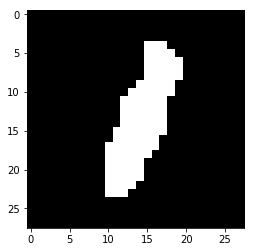

In [59]:
from scipy.misc import imresize
s = 100

max_anomalous_score, max_anomalous_index = max(zeros, key=lambda a: a[0])
max_anomalous_index = max_anomalous_index.astype(np.int)

print("Most anomalous inlier")
print(max_anomalous_score)
print("label", y_test[max_anomalous_index])
im = x_test[max_anomalous_index].reshape(28, 28)
plt.imshow(im)
im = imresize(im, (s, s))
plt.imsave('./mnist_autoencoder_digit_0_%dh_most_anomalous_inlier.jpg' % n_hidden, im)
plt.show()


min_anomalous_score, min_anomalous_index = min(not_zeros, key=lambda a: a[0])
min_anomalous_index = min_anomalous_index.astype(np.int)

print("Least anomalous outlier")
print(min_anomalous_score)
print("label", y_test[min_anomalous_index])
im = x_test[min_anomalous_index].reshape(28, 28)
plt.imshow(im)
im = imresize(im, (s, s))
plt.imsave('./outlier-1-from-0.jpg', im)
plt.show()

Find the KNN distance between all test 0's and the training set, then the distance between the weird 6 and the training set

In [60]:
print(min_anomalous_score)
print(min(zeros, key=lambda x: x[0]))
len([z for z in zeros if z[0] < min_anomalous_score])

0.07151395827531815
[8.12633559e-02 7.70300000e+03]


0

## 1-NN distance comparison in latent space

In [61]:
from sklearn.neighbors import KNeighborsClassifier

knn_latent = KNeighborsClassifier(n_neighbors=1, leaf_size=100, metric="euclidean", n_jobs=4)

# Convert the train set to the latent representation
zeros_train = x_train[y_train == digit]
zeros_train = encoders[1].predict(zeros_train)

# Train the KNN classifier
knn_latent.fit(zeros_train, np.zeros(len(zeros_train)))

# Predict distances for the test set of zeros
zeros_test = x_test[y_test == digit]
zeros_test = encoders[1].predict(zeros_test)

distances, _ = knn_latent.kneighbors(zeros_test)

In [62]:
print("mean", distances.mean())
print("std", distances.std())

mean 3.9028962328088834
std 0.9388293221106973


In [63]:
# Get KNN distance for the weird 6
outlier = encoders[digit].predict(x_test[min_anomalous_index:min_anomalous_index+1])

d, _ = knn_latent.kneighbors(outlier)
d = d[0][0]
print(d)

print("z score", (d - distances.mean()) / distances.std())

11.786928057449147
z score 8.397726443945324


## 1-NN distance comparison in original space

In [64]:
from sklearn.neighbors import KNeighborsClassifier

knn_orig = KNeighborsClassifier(n_neighbors=1, leaf_size=100, metric="euclidean", n_jobs=4)

# Convert the train set to the latent representation
zeros_train = x_train[y_train == digit]
zeros_train = zeros_train.reshape((len(zeros_train), np.prod(zeros_train.shape[1:])))

# Train the KNN classifier
knn_orig.fit(zeros_train, np.zeros(len(zeros_train)))

# Predict distances for the test set of zeros
zeros_test = x_test[y_test == digit]
zeros_test = zeros_test.reshape((len(zeros_test), np.prod(zeros_test.shape[1:])))

distances, _ = knn_orig.kneighbors(zeros_test)

In [65]:
print("mean", distances.mean())
print("std", distances.std())


mean 4.4605885127591565
std 0.7770937861510842


In [66]:
# Get KNN distance for the weird 6
outlier = x_test[min_anomalous_index:min_anomalous_index+1].reshape(1, 784)

d, _ = knn_orig.kneighbors(outlier)
d = d[0][0]

print("d", d)
print("z-score", (d - distances.mean())/distances.std())

d 6.016059528930835
z-score 2.001651594559606


# KNN anomaly detector experiment

In [67]:
knn_model = KNeighborsClassifier(n_neighbors=3, leaf_size=100, metric="euclidean", n_jobs=4)

zeros_train = x_train[y_train == digit]
zeros_train = zeros_train.reshape((len(zeros_train), np.prod(zeros_train.shape[1:])))

In [68]:
knn_model.fit(zeros_train, np.zeros(len(zeros_train)))

KNeighborsClassifier(algorithm='auto', leaf_size=100, metric='euclidean',
           metric_params=None, n_jobs=4, n_neighbors=3, p=2,
           weights='uniform')

In [69]:
distances, _ = knn_model.kneighbors(x_test.reshape(len(x_test), np.prod(x_test.shape[1:])))

In [70]:
distances = np.mean(distances, axis=-1)

roc 0.9942273406036471


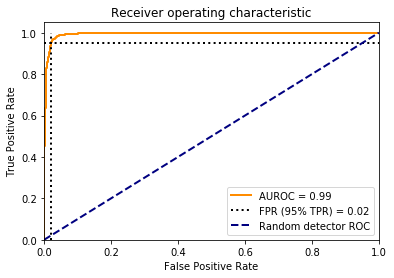

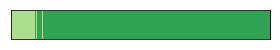

In [71]:
print("roc", roc_auc_score((y_test != digit).astype(np.int), distances))
plot_roc(distances, (y_test != digit).astype(np.int))
barcode_plot(distances, (y_test != digit).astype(np.int))

Most anomalous inlier
dist 8.189405683278094
label 0


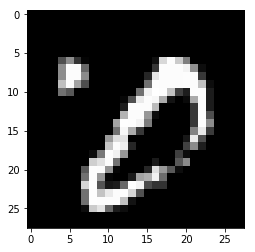

Least anomalous outlier
dist 4.607066742489409
label 6


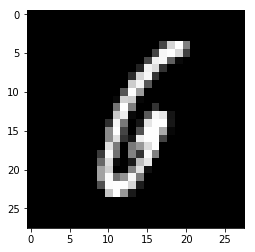

In [72]:
zeros = np.array([(score, index) for index, score in enumerate(distances)])
not_zeros = zeros[y_test != digit]
zeros = zeros[y_test == digit]

max_anomalous_score, max_anomalous_index = max(zeros, key=lambda a: a[0])
max_anomalous_index = max_anomalous_index.astype(np.int)

print("Most anomalous inlier")
print("dist", max_anomalous_score)
print("label", y_test[max_anomalous_index])
plt.imshow(x_test[max_anomalous_index].reshape(28, 28))
plt.show()


min_anomalous_score, min_anomalous_index = min(not_zeros, key=lambda a: a[0])
min_anomalous_index = min_anomalous_index.astype(np.int)

print("Least anomalous outlier")
print("dist", min_anomalous_score)
print("label", y_test[min_anomalous_index])
plt.imshow(x_test[min_anomalous_index].reshape(28, 28))
plt.show()

# KNN anomaly detector experiment in latent space

In [73]:
knn_model = KNeighborsClassifier(n_neighbors=3, leaf_size=100, metric="euclidean", n_jobs=4)

zeros_train = x_train[y_train == digit]
zeros_train = encoders[digit].predict(zeros_train)

In [74]:
knn_model.fit(zeros_train, np.zeros(len(zeros_train)))

KNeighborsClassifier(algorithm='auto', leaf_size=100, metric='euclidean',
           metric_params=None, n_jobs=4, n_neighbors=3, p=2,
           weights='uniform')

In [75]:
encoded_test = encoders[digit].predict(x_test)
distances, _ = knn_model.kneighbors(encoded_test)

In [76]:
distances = np.mean(distances, axis=-1)

roc 0.991300285080773


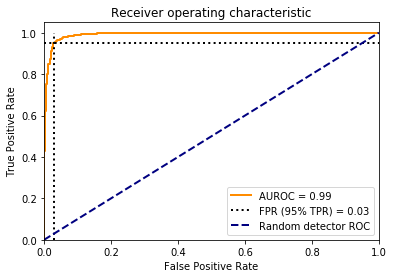

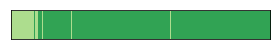

In [77]:
print("roc", roc_auc_score((y_test != digit).astype(np.int), distances))
plot_roc(distances, (y_test != digit).astype(np.int))
barcode_plot(distances, (y_test != digit).astype(np.int))

Most anomalous inlier
dist 5.889163555416658
label 0


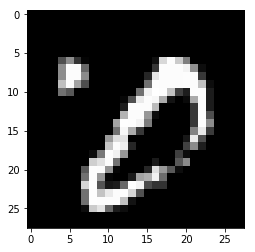

Least anomalous outlier
dist 2.4286794968142713
label 6


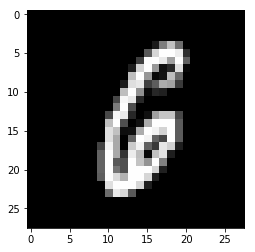

In [78]:
zeros = np.array([(score, index) for index, score in enumerate(distances)])
not_zeros = zeros[y_test != digit]
zeros = zeros[y_test == digit]

max_anomalous_score, max_anomalous_index = max(zeros, key=lambda a: a[0])
max_anomalous_index = max_anomalous_index.astype(np.int)

print("Most anomalous inlier")
print("dist", max_anomalous_score)
print("label", y_test[max_anomalous_index])
plt.imshow(x_test[max_anomalous_index].reshape(28, 28))
plt.show()


min_anomalous_score, min_anomalous_index = min(not_zeros, key=lambda a: a[0])
min_anomalous_index = min_anomalous_index.astype(np.int)

print("Least anomalous outlier")
print("dist", min_anomalous_score)
print("label", y_test[min_anomalous_index])
plt.imshow(x_test[min_anomalous_index].reshape(28, 28))
plt.show()

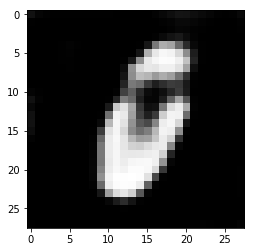

In [79]:
plt.imshow(autoencoders[digit].predict(x_test[min_anomalous_index:min_anomalous_index+1]).reshape((28,28)))

## Try a hybrid anomaly detector approach

In [80]:
# First we need to find a way to normalize the values from the autoencoder 
#    and the KNN model working on the latent space

# To do this, we will just look at reconstruction loss on the training set of 0s

# Then look at the average distance in latent space of the training set of 0s

# Then we can do min-max or mean std scaling

In [81]:
zeros_val = x_val[y_val == digit]

zeros_val_recon_errors = anomaly_detector.predict(zeros_val)[digit]

recon_max = np.max(zeros_val_recon_errors)
recon_min = np.min(zeros_val_recon_errors)

In [82]:
zeros_val_encoded = encoders[digit].predict(zeros_val)

In [83]:
train_encoded = encoders[digit].predict(x_train[y_train == digit])

nn_distance = KNeighborsClassifier(1, metric='euclidean')
nn_distance.fit(train_encoded, np.zeros(len(train_encoded)))

distances, _ = nn_distance.kneighbors(zeros_val_encoded)

dist_max = np.max(distances)
dist_min = np.min(distances)

In [84]:
# Calculate AUROC using average normalized latent distance and recon error as the novelty score

recon_error_test = anomaly_detector.predict(x_test)[digit]

def minmax_scale(val, mx, mn):
    return (val - mn) / (mx - mn)

def stdnorm_scale(val, mean, std):
    return (val - mean) / std


recon_error_test = minmax_scale(recon_error_test, recon_max, recon_min)

In [85]:
test_encoded = encoders[digit].predict(x_test)

distances_test, _ = nn_distance.kneighbors(test_encoded)
distances_test = minmax_scale(distances_test, dist_max, dist_min)
distances_test = np.squeeze(distances_test)

roc 0.984614801574732


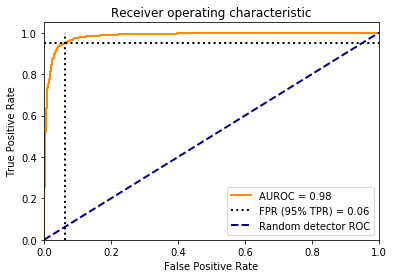

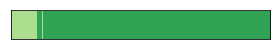

In [86]:
novelty_score_test = recon_error_test + distances_test

labels_test = (y_test != digit).astype(np.int)

print("roc", roc_auc_score(labels_test, novelty_score_test))
plot_roc(novelty_score_test, labels_test)
barcode_plot(novelty_score_test, labels_test)

<IPython.core.display.Javascript object>


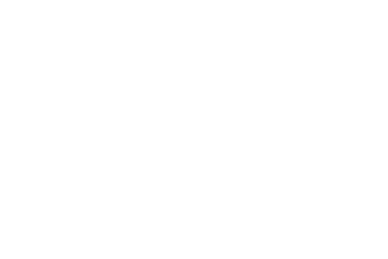

<IPython.core.display.Javascript object>


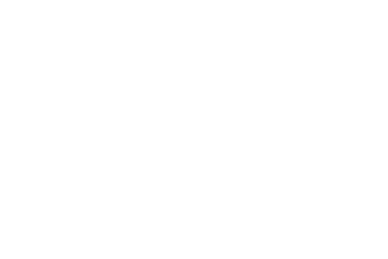

In [87]:
%matplotlib notebook

plt.figure()
plt.scatter(distances_test[labels_test.astype(np.bool)], recon_error_test[labels_test.astype(np.bool)], c='#31a354')
plt.scatter(distances_test[~labels_test.astype(np.bool)], recon_error_test[~labels_test.astype(np.bool)], c='#addd8e')
plt.xlabel("1NN distance in latent space")
plt.ylabel("Reconstruction error")
plt.show()

In [88]:
%matplotlib inline

In [89]:
# First we need to find a way to normalize the values from the autoencoder 
#    and the KNN model working on the latent space

# To do this, we will just look at reconstruction loss on the training set of 0s

# Then look at the average distance in latent space of the training set of 0s

# Then we can do min-max or mean std scaling

In [90]:
zeros_val = x_val[y_val == digit]

zeros_val_recon_errors = anomaly_detector.predict(zeros_val)[digit]

recon_mean = np.mean(zeros_val_recon_errors)
recon_std = np.std(zeros_val_recon_errors)

In [91]:
zeros_val_encoded = encoders[digit].predict(zeros_val)

In [92]:
train_encoded = encoders[digit].predict(x_train[y_train == digit])

nn_distance = KNeighborsClassifier(1, metric='euclidean')
nn_distance.fit(train_encoded, np.zeros(len(train_encoded)))

distances, _ = nn_distance.kneighbors(zeros_val_encoded)

dist_mean = np.mean(distances)
dist_std = np.std(distances)

In [93]:
# Calculate AUROC using average normalized latent distance and recon error as the novelty score

recon_error_test = anomaly_detector.predict(x_test)[digit]

def minmax_scale(val, mx, mn):
    return (val - mn) / (mx - mn)

def stdnorm_scale(val, mean, std):
    return val
    return (val - mean) / std

recon_error_test = stdnorm_scale(recon_error_test, recon_mean, recon_std)

In [94]:
test_encoded = encoders[digit].predict(x_test)

distances_test, _ = nn_distance.kneighbors(test_encoded)
distances_test = stdnorm_scale(distances_test, dist_mean, dist_std)
distances_test = np.squeeze(distances_test)

roc 0.9900633512828635


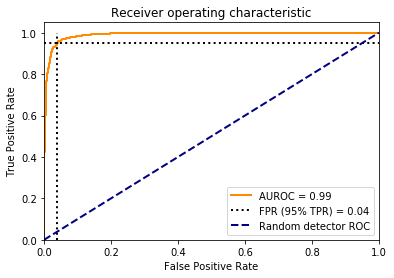

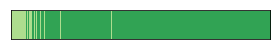

In [95]:
novelty_score_test = recon_error_test + distances_test

labels_test = (y_test != digit).astype(np.int)

print("roc", roc_auc_score(labels_test, novelty_score_test))
plot_roc(novelty_score_test, labels_test)
barcode_plot(novelty_score_test, labels_test)

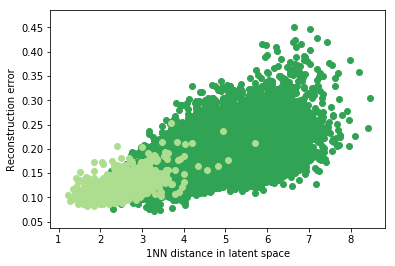

In [96]:
plt.scatter(distances_test[labels_test.astype(np.bool)], recon_error_test[labels_test.astype(np.bool)], c='#31a354')
plt.scatter(distances_test[~labels_test.astype(np.bool)], recon_error_test[~labels_test.astype(np.bool)], c='#addd8e')
plt.xlabel("1NN distance in latent space")
plt.ylabel("Reconstruction error")
plt.show()

# Correlation between variance in latent space and reconstruction error

In [97]:
recon_error_test = anomaly_detector.predict(x_test)[digit]
encoded_test = encoders[digit].predict(x_test)

encoded_var_test = np.var(encoded_test, axis=-1)

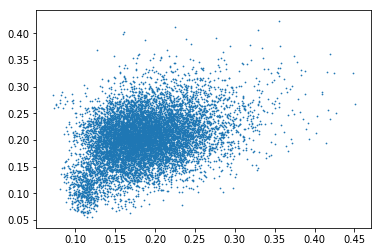

In [98]:
plt.scatter(recon_error_test, encoded_var_test, s=0.5)
plt.show()

# Relationship between KNN distance and Reconstruction error with different autoencoder bottleneck size

Training autoencoder 0 8


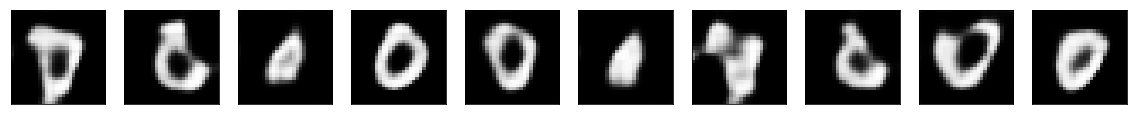

Training autoencoder 0 16


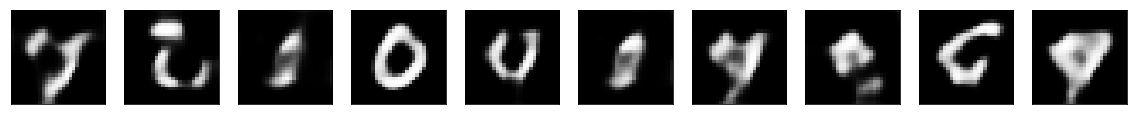

Training autoencoder 0 32


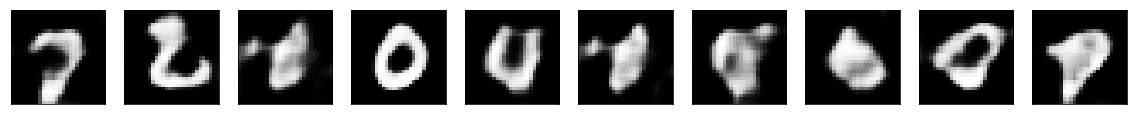

Training autoencoder 0 64


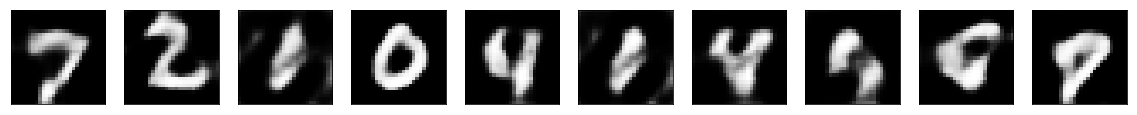

Training autoencoder 0 128


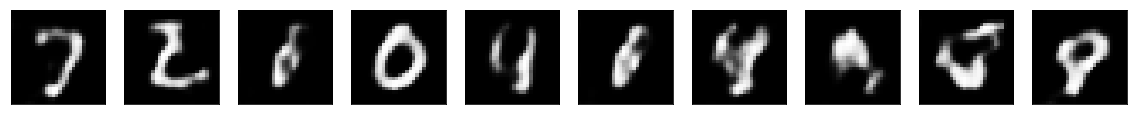

Training autoencoder 0 256


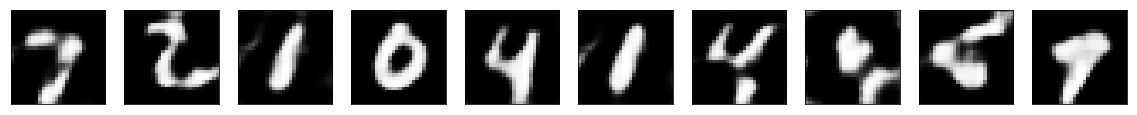

Training autoencoder 0 512


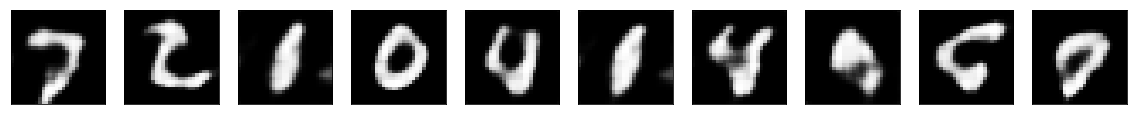

Training autoencoder 0 798


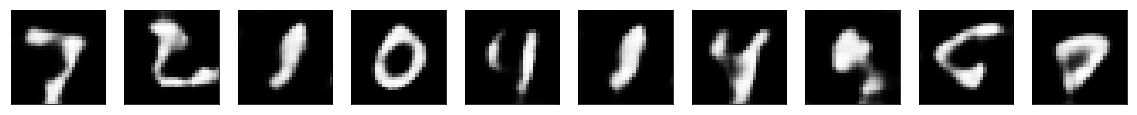

Training autoencoder 0 1024


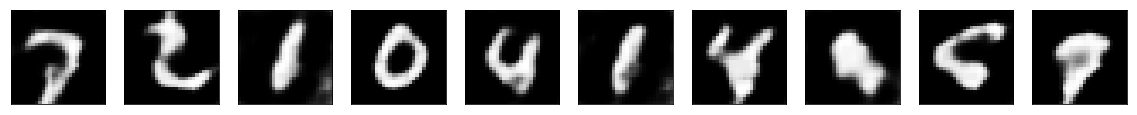

Training autoencoder 1 8
Train on 5649 samples, validate on 1135 samples
Epoch 1/50
5649/5649 [==============================] - 2s 311us/step - loss: 0.4870 - val_loss: 0.1624
Epoch 2/50
5649/5649 [==============================] - 1s 111us/step - loss: 0.1474 - val_loss: 0.1380
Epoch 3/50
5649/5649 [==============================] - 1s 112us/step - loss: 0.1290 - val_loss: 0.1347
Epoch 4/50
5649/5649 [==============================] - 1s 106us/step - loss: 0.1119 - val_loss: 0.1179
Epoch 5/50
5649/5649 [==============================] - 1s 102us/step - loss: 0.1024 - val_loss: 0.0985
Epoch 6/50
5649/5649 [==============================] - 1s 102us/step - loss: 0.0953 - val_loss: 0.0977
Epoch 7/50
5649/5649 [==============================] - 1s 101us/step - loss: 0.0923 - val_loss: 0.0827
Epoch 8/50
5649/5649 [==============================] - 1s 102us/step - loss: 0.0886 - val_loss: 0.0885
Epoch 9/50
5649/5649 [==============================] - 1s 102us/step - loss: 0.0870 - val_loss

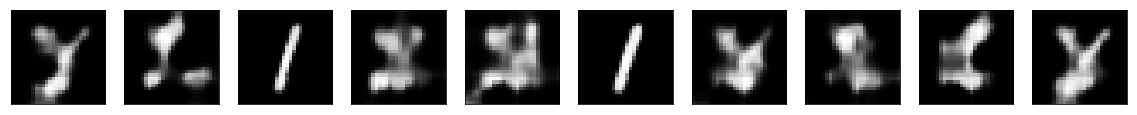

Training autoencoder 1 16
Train on 5649 samples, validate on 1135 samples
Epoch 1/50
5649/5649 [==============================] - 2s 288us/step - loss: 0.6065 - val_loss: 0.3896
Epoch 2/50
5649/5649 [==============================] - 1s 103us/step - loss: 0.3064 - val_loss: 0.2835
Epoch 3/50
5649/5649 [==============================] - 1s 105us/step - loss: 0.2389 - val_loss: 0.1676
Epoch 4/50
5649/5649 [==============================] - 1s 108us/step - loss: 0.1385 - val_loss: 0.1097
Epoch 5/50
5649/5649 [==============================] - 1s 105us/step - loss: 0.1056 - val_loss: 0.1004
Epoch 6/50
5649/5649 [==============================] - 1s 106us/step - loss: 0.0965 - val_loss: 0.0921
Epoch 7/50
5649/5649 [==============================] - 1s 107us/step - loss: 0.0901 - val_loss: 0.0893
Epoch 8/50
5649/5649 [==============================] - 1s 107us/step - loss: 0.0857 - val_loss: 0.0840
Epoch 9/50
5649/5649 [==============================] - 1s 102us/step - loss: 0.0817 - val_los

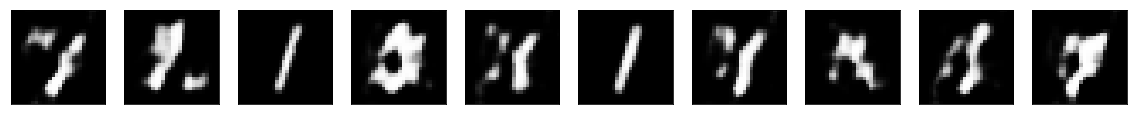

Training autoencoder 1 32
Train on 5649 samples, validate on 1135 samples
Epoch 1/50
5649/5649 [==============================] - 2s 315us/step - loss: 0.4477 - val_loss: 0.1473
Epoch 2/50
5649/5649 [==============================] - 1s 105us/step - loss: 0.1387 - val_loss: 0.1308
Epoch 3/50
5649/5649 [==============================] - 1s 111us/step - loss: 0.1247 - val_loss: 0.1183
Epoch 4/50
5649/5649 [==============================] - 1s 106us/step - loss: 0.1120 - val_loss: 0.1081
Epoch 5/50
5649/5649 [==============================] - 1s 108us/step - loss: 0.1013 - val_loss: 0.0981
Epoch 6/50
5649/5649 [==============================] - 1s 108us/step - loss: 0.0964 - val_loss: 0.0930
Epoch 7/50
5649/5649 [==============================] - 1s 107us/step - loss: 0.0928 - val_loss: 0.0965
Epoch 8/50
5649/5649 [==============================] - 1s 106us/step - loss: 0.0893 - val_loss: 0.0885
Epoch 9/50
5649/5649 [==============================] - 1s 109us/step - loss: 0.0871 - val_los

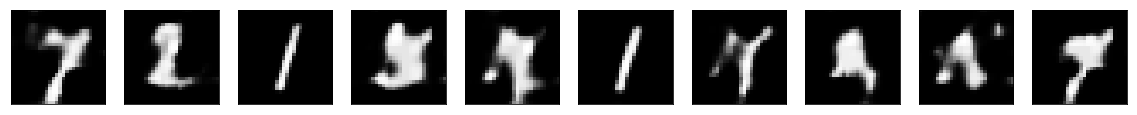

Training autoencoder 1 64


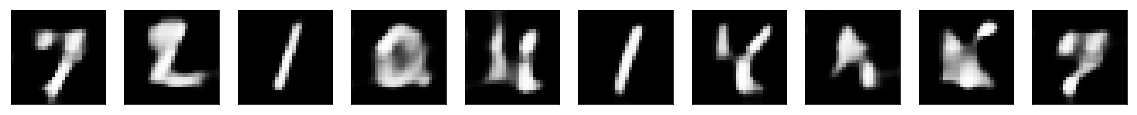

Training autoencoder 1 128


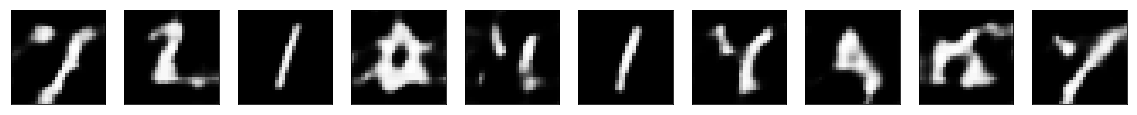

Training autoencoder 1 256


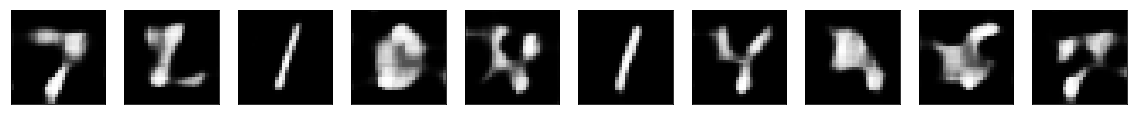

Training autoencoder 1 512
Train on 5649 samples, validate on 1135 samples
Epoch 1/50
5649/5649 [==============================] - 2s 350us/step - loss: 0.3717 - val_loss: 0.1485
Epoch 2/50
5649/5649 [==============================] - 1s 114us/step - loss: 0.1346 - val_loss: 0.1275
Epoch 3/50
5649/5649 [==============================] - 1s 114us/step - loss: 0.1239 - val_loss: 0.1199
Epoch 4/50
5649/5649 [==============================] - 1s 114us/step - loss: 0.1175 - val_loss: 0.1141
Epoch 5/50
5649/5649 [==============================] - 1s 114us/step - loss: 0.1114 - val_loss: 0.1070
Epoch 6/50
5649/5649 [==============================] - 1s 115us/step - loss: 0.1051 - val_loss: 0.1017
Epoch 7/50
5649/5649 [==============================] - 1s 116us/step - loss: 0.0991 - val_loss: 0.0972
Epoch 8/50
5649/5649 [==============================] - 1s 118us/step - loss: 0.0935 - val_loss: 0.0887
Epoch 9/50
5649/5649 [==============================] - 1s 115us/step - loss: 0.0897 - val_lo

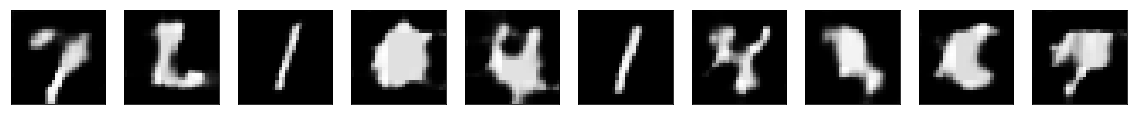

Training autoencoder 1 798
Train on 5649 samples, validate on 1135 samples
Epoch 1/50
5649/5649 [==============================] - 2s 366us/step - loss: 0.3246 - val_loss: 0.1532
Epoch 2/50
5649/5649 [==============================] - 1s 128us/step - loss: 0.1158 - val_loss: 0.1006
Epoch 3/50
5649/5649 [==============================] - 1s 125us/step - loss: 0.0994 - val_loss: 0.1025
Epoch 4/50
5649/5649 [==============================] - 1s 125us/step - loss: 0.0928 - val_loss: 0.0882
Epoch 5/50
5649/5649 [==============================] - 1s 119us/step - loss: 0.0901 - val_loss: 0.0909
Epoch 6/50
5649/5649 [==============================] - 1s 119us/step - loss: 0.0847 - val_loss: 0.0757
Epoch 7/50
5649/5649 [==============================] - 1s 120us/step - loss: 0.0796 - val_loss: 0.0793
Epoch 8/50
5649/5649 [==============================] - 1s 130us/step - loss: 0.0781 - val_loss: 0.0842
Epoch 9/50
5649/5649 [==============================] - 1s 124us/step - loss: 0.0745 - val_lo

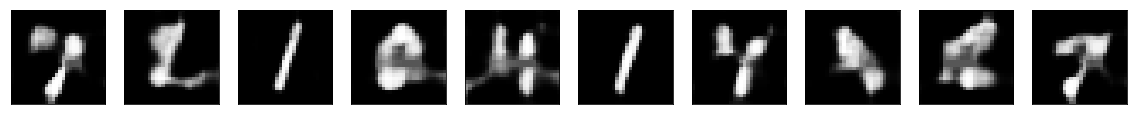

Training autoencoder 1 1024
Train on 5649 samples, validate on 1135 samples
Epoch 1/50
5649/5649 [==============================] - 2s 382us/step - loss: 0.4290 - val_loss: 0.1487
Epoch 2/50
5649/5649 [==============================] - 1s 125us/step - loss: 0.1350 - val_loss: 0.1173
Epoch 3/50
5649/5649 [==============================] - 1s 125us/step - loss: 0.1125 - val_loss: 0.0956
Epoch 4/50
5649/5649 [==============================] - 1s 125us/step - loss: 0.0955 - val_loss: 0.0887
Epoch 5/50
5649/5649 [==============================] - 1s 125us/step - loss: 0.0873 - val_loss: 0.0829
Epoch 6/50
5649/5649 [==============================] - 1s 130us/step - loss: 0.0857 - val_loss: 0.0817
Epoch 7/50
5649/5649 [==============================] - 1s 129us/step - loss: 0.0803 - val_loss: 0.0775
Epoch 8/50
5649/5649 [==============================] - 1s 125us/step - loss: 0.0760 - val_loss: 0.0800
Epoch 9/50
5649/5649 [==============================] - 1s 125us/step - loss: 0.0738 - val_l

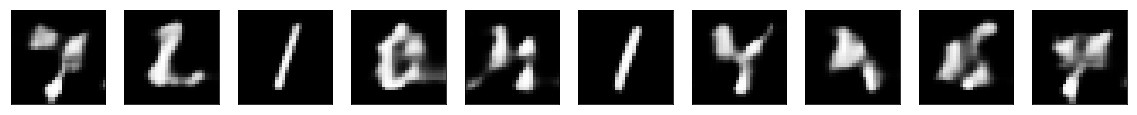

Training autoencoder 2 8
Train on 4964 samples, validate on 1032 samples
Epoch 1/50
4964/4964 [==============================] - 2s 426us/step - loss: 0.6298 - val_loss: 0.4332
Epoch 2/50
4964/4964 [==============================] - 1s 104us/step - loss: 0.3269 - val_loss: 0.2707
Epoch 3/50
4964/4964 [==============================] - 1s 113us/step - loss: 0.2653 - val_loss: 0.2527
Epoch 4/50
4964/4964 [==============================] - 1s 107us/step - loss: 0.2516 - val_loss: 0.2415
Epoch 5/50
4964/4964 [==============================] - 1s 108us/step - loss: 0.2387 - val_loss: 0.2348
Epoch 6/50
4964/4964 [==============================] - 1s 108us/step - loss: 0.2298 - val_loss: 0.2264
Epoch 7/50
4964/4964 [==============================] - 1s 108us/step - loss: 0.2203 - val_loss: 0.2194
Epoch 8/50
4964/4964 [==============================] - 1s 111us/step - loss: 0.2148 - val_loss: 0.2084
Epoch 9/50
4964/4964 [==============================] - 1s 111us/step - loss: 0.2084 - val_loss

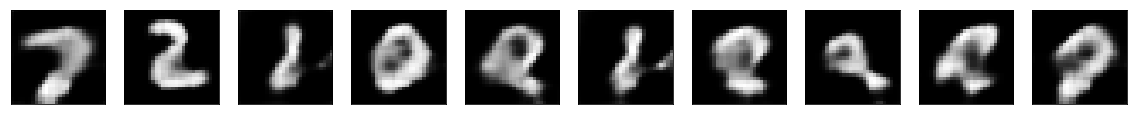

Training autoencoder 2 16
Train on 4964 samples, validate on 1032 samples
Epoch 1/50
4964/4964 [==============================] - 2s 406us/step - loss: 0.5753 - val_loss: 0.3019
Epoch 2/50
4964/4964 [==============================] - 1s 104us/step - loss: 0.2899 - val_loss: 0.2774
Epoch 3/50
4964/4964 [==============================] - 1s 104us/step - loss: 0.2730 - val_loss: 0.2628
Epoch 4/50
4964/4964 [==============================] - 1s 104us/step - loss: 0.2634 - val_loss: 0.2524
Epoch 5/50
4964/4964 [==============================] - 1s 104us/step - loss: 0.2482 - val_loss: 0.2405
Epoch 6/50
4964/4964 [==============================] - 1s 104us/step - loss: 0.2343 - val_loss: 0.2204
Epoch 7/50
4964/4964 [==============================] - 1s 111us/step - loss: 0.2195 - val_loss: 0.2115
Epoch 8/50
4964/4964 [==============================] - 1s 109us/step - loss: 0.2111 - val_loss: 0.1995
Epoch 9/50
4964/4964 [==============================] - 1s 107us/step - loss: 0.1992 - val_los

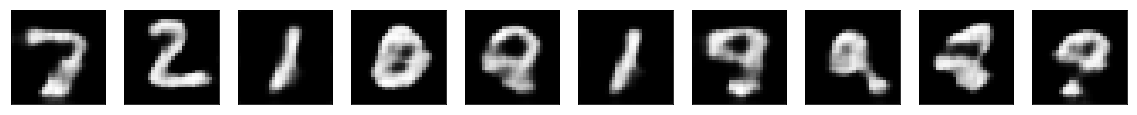

Training autoencoder 2 32
Train on 4964 samples, validate on 1032 samples
Epoch 1/50
4964/4964 [==============================] - 2s 415us/step - loss: 0.6229 - val_loss: 0.3920
Epoch 2/50
4964/4964 [==============================] - 1s 104us/step - loss: 0.2973 - val_loss: 0.2666
Epoch 3/50
4964/4964 [==============================] - 1s 104us/step - loss: 0.2618 - val_loss: 0.2561
Epoch 4/50
4964/4964 [==============================] - 1s 104us/step - loss: 0.2400 - val_loss: 0.2258
Epoch 5/50
4964/4964 [==============================] - 1s 106us/step - loss: 0.2223 - val_loss: 0.2211
Epoch 6/50
4964/4964 [==============================] - 1s 108us/step - loss: 0.2119 - val_loss: 0.2093
Epoch 7/50
4964/4964 [==============================] - 1s 111us/step - loss: 0.2048 - val_loss: 0.2004
Epoch 8/50
4964/4964 [==============================] - 1s 106us/step - loss: 0.1946 - val_loss: 0.2002
Epoch 9/50
4964/4964 [==============================] - 1s 104us/step - loss: 0.1893 - val_los

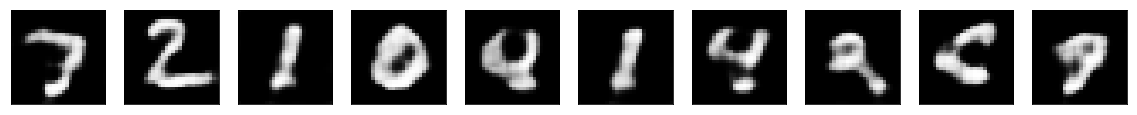

Training autoencoder 2 64


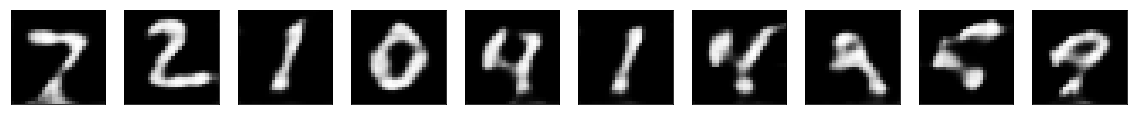

Training autoencoder 2 128


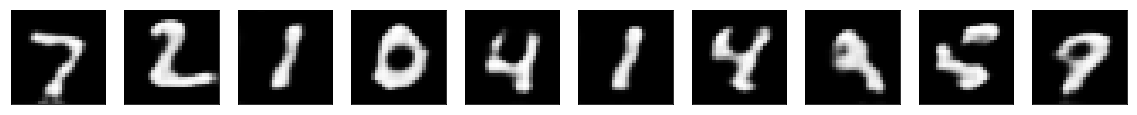

Training autoencoder 2 256


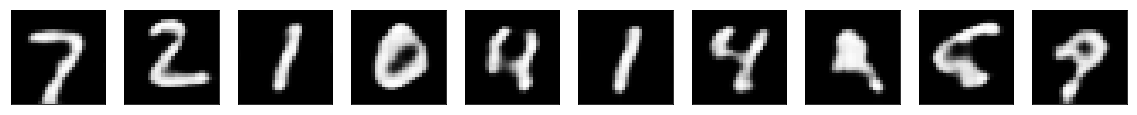

Training autoencoder 2 512
Train on 4964 samples, validate on 1032 samples
Epoch 1/50
4964/4964 [==============================] - 2s 429us/step - loss: 0.4994 - val_loss: 0.3007
Epoch 2/50
4964/4964 [==============================] - 1s 116us/step - loss: 0.2845 - val_loss: 0.2695
Epoch 3/50
4964/4964 [==============================] - 1s 115us/step - loss: 0.2658 - val_loss: 0.2577
Epoch 4/50
4964/4964 [==============================] - 1s 116us/step - loss: 0.2515 - val_loss: 0.2398
Epoch 5/50
4964/4964 [==============================] - 1s 116us/step - loss: 0.2361 - val_loss: 0.2262
Epoch 6/50
4964/4964 [==============================] - 1s 116us/step - loss: 0.2249 - val_loss: 0.2283
Epoch 7/50
4964/4964 [==============================] - 1s 115us/step - loss: 0.2149 - val_loss: 0.2064
Epoch 8/50
4964/4964 [==============================] - 1s 116us/step - loss: 0.2048 - val_loss: 0.1973
Epoch 9/50
4964/4964 [==============================] - 1s 116us/step - loss: 0.2004 - val_lo

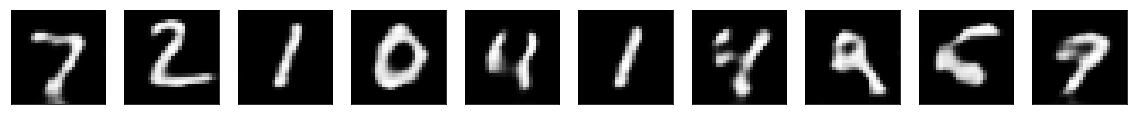

Training autoencoder 2 798
Train on 4964 samples, validate on 1032 samples
Epoch 1/50
4964/4964 [==============================] - 2s 461us/step - loss: 0.4574 - val_loss: 0.2955
Epoch 2/50
4964/4964 [==============================] - 1s 123us/step - loss: 0.2861 - val_loss: 0.2715
Epoch 3/50
4964/4964 [==============================] - 1s 122us/step - loss: 0.2685 - val_loss: 0.2573
Epoch 4/50
4964/4964 [==============================] - 1s 122us/step - loss: 0.2549 - val_loss: 0.2465
Epoch 5/50
4964/4964 [==============================] - 1s 122us/step - loss: 0.2420 - val_loss: 0.2388
Epoch 6/50
4964/4964 [==============================] - 1s 121us/step - loss: 0.2347 - val_loss: 0.2254
Epoch 7/50
4964/4964 [==============================] - 1s 123us/step - loss: 0.2258 - val_loss: 0.2191
Epoch 8/50
4964/4964 [==============================] - 1s 128us/step - loss: 0.2158 - val_loss: 0.2155
Epoch 9/50
4964/4964 [==============================] - 1s 121us/step - loss: 0.2089 - val_lo

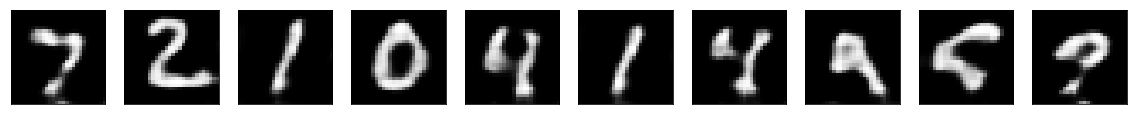

Training autoencoder 2 1024
Train on 4964 samples, validate on 1032 samples
Epoch 1/50
4964/4964 [==============================] - 2s 487us/step - loss: 0.4490 - val_loss: 0.2742
Epoch 2/50
4964/4964 [==============================] - 1s 127us/step - loss: 0.2715 - val_loss: 0.2616
Epoch 3/50
4964/4964 [==============================] - 1s 126us/step - loss: 0.2573 - val_loss: 0.2471
Epoch 4/50
4964/4964 [==============================] - 1s 126us/step - loss: 0.2442 - val_loss: 0.2388
Epoch 5/50
4964/4964 [==============================] - 1s 126us/step - loss: 0.2310 - val_loss: 0.2194
Epoch 6/50
4964/4964 [==============================] - 1s 126us/step - loss: 0.2192 - val_loss: 0.2100
Epoch 7/50
4964/4964 [==============================] - 1s 126us/step - loss: 0.2102 - val_loss: 0.2038
Epoch 8/50
4964/4964 [==============================] - 1s 126us/step - loss: 0.2011 - val_loss: 0.1890
Epoch 9/50
4964/4964 [==============================] - 1s 126us/step - loss: 0.1917 - val_l

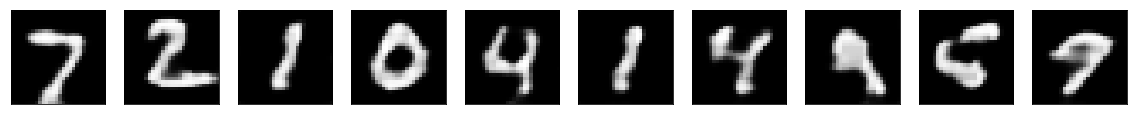

Training autoencoder 3 8
Train on 5131 samples, validate on 1010 samples
Epoch 1/50
5131/5131 [==============================] - 3s 657us/step - loss: 0.5939 - val_loss: 0.3375
Epoch 2/50
5131/5131 [==============================] - 1s 111us/step - loss: 0.2917 - val_loss: 0.2697
Epoch 3/50
5131/5131 [==============================] - 1s 113us/step - loss: 0.2636 - val_loss: 0.2590
Epoch 4/50
5131/5131 [==============================] - 1s 111us/step - loss: 0.2474 - val_loss: 0.2324
Epoch 5/50
5131/5131 [==============================] - 1s 111us/step - loss: 0.2304 - val_loss: 0.2507
Epoch 6/50
5131/5131 [==============================] - 1s 112us/step - loss: 0.2206 - val_loss: 0.2171
Epoch 7/50
5131/5131 [==============================] - 1s 111us/step - loss: 0.2128 - val_loss: 0.2058
Epoch 8/50
5131/5131 [==============================] - 1s 109us/step - loss: 0.2049 - val_loss: 0.2097
Epoch 9/50
5131/5131 [==============================] - 1s 110us/step - loss: 0.1988 - val_loss

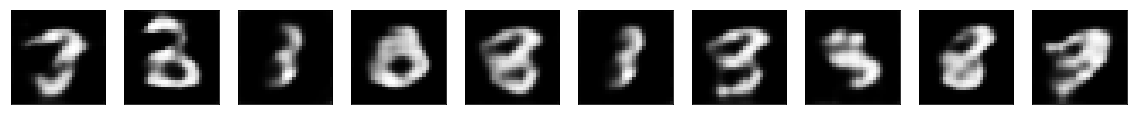

Training autoencoder 3 16
Train on 5131 samples, validate on 1010 samples
Epoch 1/50
5131/5131 [==============================] - 3s 512us/step - loss: 0.6232 - val_loss: 0.4364
Epoch 2/50
5131/5131 [==============================] - 1s 108us/step - loss: 0.3508 - val_loss: 0.2701
Epoch 3/50
5131/5131 [==============================] - 1s 105us/step - loss: 0.2498 - val_loss: 0.2328
Epoch 4/50
5131/5131 [==============================] - 1s 105us/step - loss: 0.2245 - val_loss: 0.2191
Epoch 5/50
5131/5131 [==============================] - 1s 107us/step - loss: 0.2087 - val_loss: 0.2100
Epoch 6/50
5131/5131 [==============================] - 1s 104us/step - loss: 0.1971 - val_loss: 0.1891
Epoch 7/50
5131/5131 [==============================] - 1s 106us/step - loss: 0.1891 - val_loss: 0.1988
Epoch 8/50
5131/5131 [==============================] - 1s 106us/step - loss: 0.1818 - val_loss: 0.1869
Epoch 9/50
5131/5131 [==============================] - 1s 106us/step - loss: 0.1768 - val_los

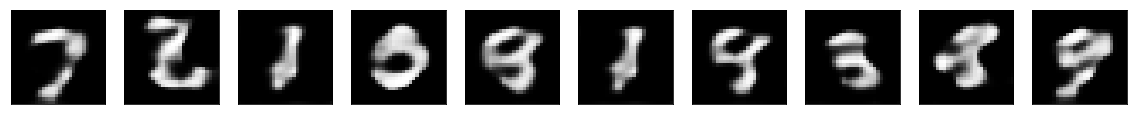

Training autoencoder 3 32
Train on 5131 samples, validate on 1010 samples
Epoch 1/50
5131/5131 [==============================] - 2s 464us/step - loss: 0.4774 - val_loss: 0.2759
Epoch 2/50
5131/5131 [==============================] - 1s 109us/step - loss: 0.2624 - val_loss: 0.2530
Epoch 3/50
5131/5131 [==============================] - 1s 108us/step - loss: 0.2436 - val_loss: 0.2366
Epoch 4/50
5131/5131 [==============================] - 1s 109us/step - loss: 0.2300 - val_loss: 0.2224
Epoch 5/50
5131/5131 [==============================] - 1s 109us/step - loss: 0.2197 - val_loss: 0.2159
Epoch 6/50
5131/5131 [==============================] - 1s 108us/step - loss: 0.2094 - val_loss: 0.2013
Epoch 7/50
5131/5131 [==============================] - 1s 108us/step - loss: 0.2044 - val_loss: 0.2141
Epoch 8/50
5131/5131 [==============================] - 1s 108us/step - loss: 0.1941 - val_loss: 0.2129
Epoch 9/50
5131/5131 [==============================] - 1s 107us/step - loss: 0.1850 - val_los

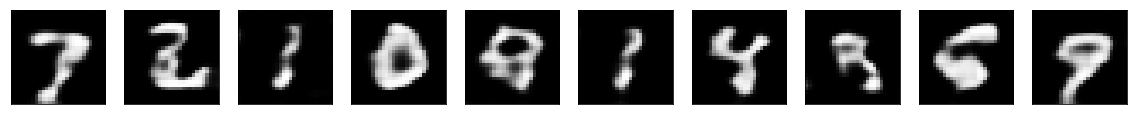

Training autoencoder 3 64


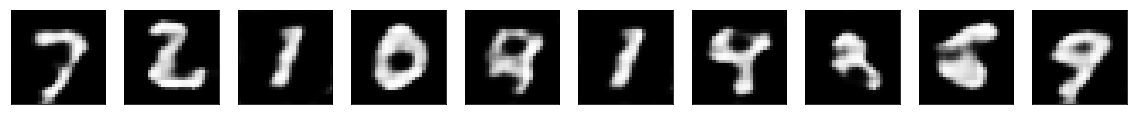

Training autoencoder 3 128


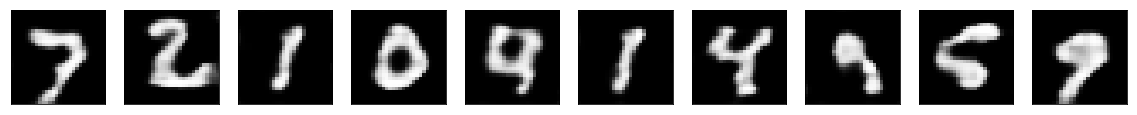

Training autoencoder 3 256


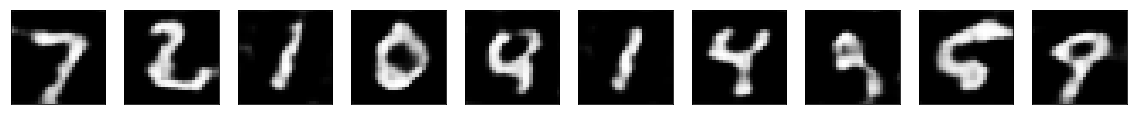

Training autoencoder 3 512
Train on 5131 samples, validate on 1010 samples
Epoch 1/50
5131/5131 [==============================] - 2s 475us/step - loss: 0.4449 - val_loss: 0.2599
Epoch 2/50
5131/5131 [==============================] - 1s 118us/step - loss: 0.2562 - val_loss: 0.2456
Epoch 3/50
5131/5131 [==============================] - 1s 118us/step - loss: 0.2424 - val_loss: 0.2337
Epoch 4/50
5131/5131 [==============================] - 1s 117us/step - loss: 0.2299 - val_loss: 0.2401
Epoch 5/50
5131/5131 [==============================] - 1s 119us/step - loss: 0.2206 - val_loss: 0.2099
Epoch 6/50
5131/5131 [==============================] - 1s 118us/step - loss: 0.2109 - val_loss: 0.2055
Epoch 7/50
5131/5131 [==============================] - 1s 118us/step - loss: 0.2066 - val_loss: 0.2018
Epoch 8/50
5131/5131 [==============================] - 1s 118us/step - loss: 0.1966 - val_loss: 0.1900
Epoch 9/50
5131/5131 [==============================] - 1s 117us/step - loss: 0.1931 - val_lo

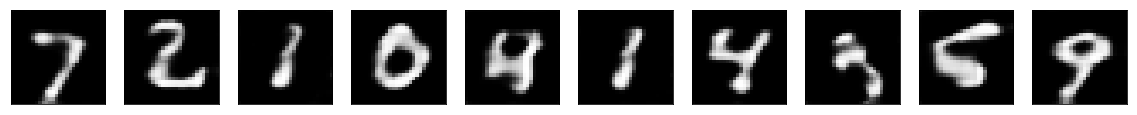

Training autoencoder 3 798
Train on 5131 samples, validate on 1010 samples
Epoch 1/50
5131/5131 [==============================] - 3s 505us/step - loss: 0.4610 - val_loss: 0.2827
Epoch 2/50
5131/5131 [==============================] - 1s 128us/step - loss: 0.2677 - val_loss: 0.2601
Epoch 3/50
5131/5131 [==============================] - 1s 123us/step - loss: 0.2473 - val_loss: 0.2462
Epoch 4/50
5131/5131 [==============================] - 1s 121us/step - loss: 0.2344 - val_loss: 0.2358
Epoch 5/50
5131/5131 [==============================] - 1s 132us/step - loss: 0.2273 - val_loss: 0.2119
Epoch 6/50
5131/5131 [==============================] - 1s 129us/step - loss: 0.2164 - val_loss: 0.2164
Epoch 7/50
5131/5131 [==============================] - 1s 123us/step - loss: 0.2102 - val_loss: 0.2065
Epoch 8/50
5131/5131 [==============================] - 1s 125us/step - loss: 0.2001 - val_loss: 0.1948
Epoch 9/50
5131/5131 [==============================] - 1s 123us/step - loss: 0.1956 - val_lo

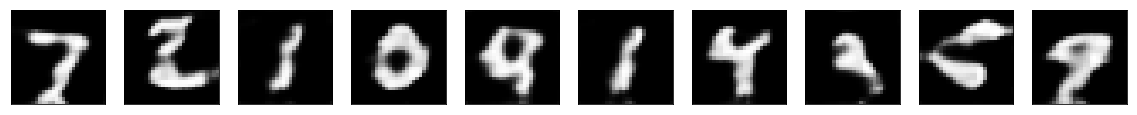

Training autoencoder 3 1024
Train on 5131 samples, validate on 1010 samples
Epoch 1/50
5131/5131 [==============================] - 5s 969us/step - loss: 0.5120 - val_loss: 0.2963
Epoch 2/50
5131/5131 [==============================] - 1s 255us/step - loss: 0.2725 - val_loss: 0.2430
Epoch 3/50
5131/5131 [==============================] - 2s 339us/step - loss: 0.2443 - val_loss: 0.2538
Epoch 4/50
5131/5131 [==============================] - 2s 297us/step - loss: 0.2319 - val_loss: 0.2140
Epoch 5/50
5131/5131 [==============================] - 1s 223us/step - loss: 0.2171 - val_loss: 0.2077
Epoch 6/50
5131/5131 [==============================] - 1s 221us/step - loss: 0.2061 - val_loss: 0.2027
Epoch 7/50
5131/5131 [==============================] - 1s 273us/step - loss: 0.1973 - val_loss: 0.1882
Epoch 8/50
5131/5131 [==============================] - 1s 232us/step - loss: 0.1905 - val_loss: 0.1763
Epoch 9/50
5131/5131 [==============================] - 1s 150us/step - loss: 0.1829 - val_l

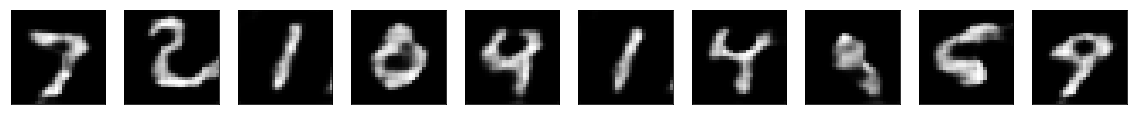

Training autoencoder 4 8
Train on 4862 samples, validate on 982 samples
Epoch 1/50
4862/4862 [==============================] - 3s 584us/step - loss: 0.5345 - val_loss: 0.2644
Epoch 2/50
4862/4862 [==============================] - 1s 111us/step - loss: 0.2411 - val_loss: 0.2313
Epoch 3/50
4862/4862 [==============================] - 1s 110us/step - loss: 0.2246 - val_loss: 0.2155
Epoch 4/50
4862/4862 [==============================] - 1s 110us/step - loss: 0.2134 - val_loss: 0.2095
Epoch 5/50
4862/4862 [==============================] - 1s 111us/step - loss: 0.2058 - val_loss: 0.1977
Epoch 6/50
4862/4862 [==============================] - 1s 112us/step - loss: 0.1981 - val_loss: 0.1929
Epoch 7/50
4862/4862 [==============================] - 1s 108us/step - loss: 0.1900 - val_loss: 0.1892
Epoch 8/50
4862/4862 [==============================] - 1s 105us/step - loss: 0.1838 - val_loss: 0.1754
Epoch 9/50
4862/4862 [==============================] - 1s 113us/step - loss: 0.1775 - val_loss:

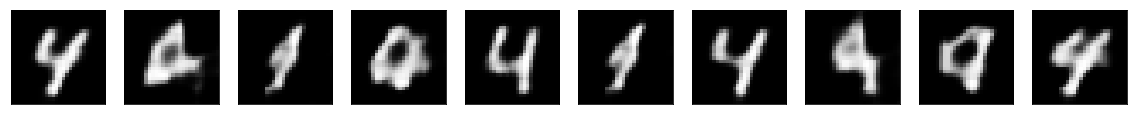

Training autoencoder 4 16
Train on 4862 samples, validate on 982 samples
Epoch 1/50
4862/4862 [==============================] - 3s 539us/step - loss: 0.5042 - val_loss: 0.2494
Epoch 2/50
4862/4862 [==============================] - 1s 108us/step - loss: 0.2404 - val_loss: 0.2332
Epoch 3/50
4862/4862 [==============================] - 1s 108us/step - loss: 0.2323 - val_loss: 0.2274
Epoch 4/50
4862/4862 [==============================] - 1s 107us/step - loss: 0.2249 - val_loss: 0.2158
Epoch 5/50
4862/4862 [==============================] - 1s 110us/step - loss: 0.2127 - val_loss: 0.2104
Epoch 6/50
4862/4862 [==============================] - 1s 110us/step - loss: 0.2051 - val_loss: 0.1964
Epoch 7/50
4862/4862 [==============================] - 1s 112us/step - loss: 0.1966 - val_loss: 0.1900
Epoch 8/50
4862/4862 [==============================] - 1s 112us/step - loss: 0.1892 - val_loss: 0.1820
Epoch 9/50
4862/4862 [==============================] - 1s 108us/step - loss: 0.1798 - val_loss

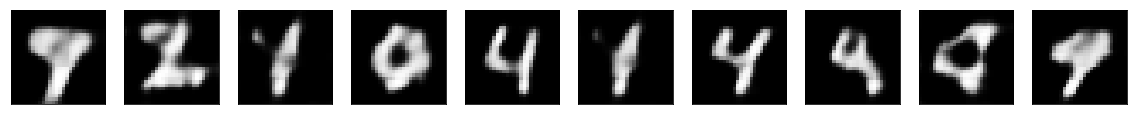

Training autoencoder 4 32
Train on 4862 samples, validate on 982 samples
Epoch 1/50
4862/4862 [==============================] - 3s 602us/step - loss: 0.4963 - val_loss: 0.2458
Epoch 2/50
4862/4862 [==============================] - 1s 111us/step - loss: 0.2397 - val_loss: 0.2355
Epoch 3/50
4862/4862 [==============================] - 1s 113us/step - loss: 0.2299 - val_loss: 0.2203
Epoch 4/50
4862/4862 [==============================] - 1s 113us/step - loss: 0.2178 - val_loss: 0.2111
Epoch 5/50
4862/4862 [==============================] - 1s 111us/step - loss: 0.2085 - val_loss: 0.2038
Epoch 6/50
4862/4862 [==============================] - 1s 114us/step - loss: 0.2002 - val_loss: 0.1918
Epoch 7/50
4862/4862 [==============================] - 1s 110us/step - loss: 0.1932 - val_loss: 0.1857
Epoch 8/50
4862/4862 [==============================] - 1s 108us/step - loss: 0.1846 - val_loss: 0.1757
Epoch 9/50
4862/4862 [==============================] - 1s 107us/step - loss: 0.1790 - val_loss

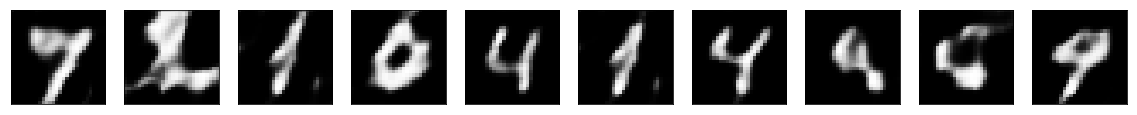

Training autoencoder 4 64


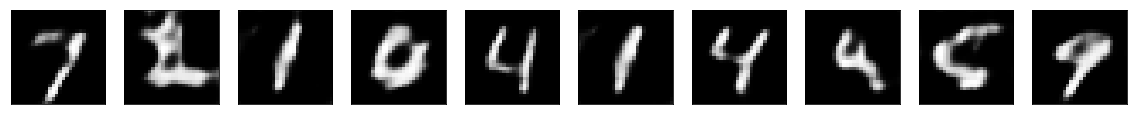

Training autoencoder 4 128


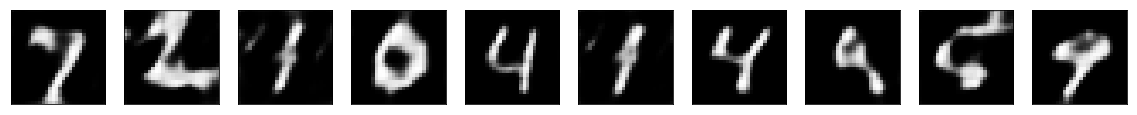

Training autoencoder 4 256


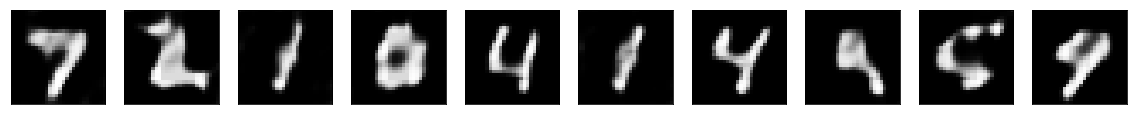

Training autoencoder 4 512
Train on 4862 samples, validate on 982 samples
Epoch 1/50
4862/4862 [==============================] - 3s 589us/step - loss: 0.5713 - val_loss: 0.2816
Epoch 2/50
4862/4862 [==============================] - 1s 119us/step - loss: 0.2445 - val_loss: 0.2325
Epoch 3/50
4862/4862 [==============================] - 1s 120us/step - loss: 0.2253 - val_loss: 0.2133
Epoch 4/50
4862/4862 [==============================] - 1s 124us/step - loss: 0.2075 - val_loss: 0.2088
Epoch 5/50
4862/4862 [==============================] - 1s 123us/step - loss: 0.1937 - val_loss: 0.1851
Epoch 6/50
4862/4862 [==============================] - 1s 122us/step - loss: 0.1810 - val_loss: 0.1659
Epoch 7/50
4862/4862 [==============================] - 1s 121us/step - loss: 0.1712 - val_loss: 0.1595
Epoch 8/50
4862/4862 [==============================] - 1s 127us/step - loss: 0.1624 - val_loss: 0.1488
Epoch 9/50
4862/4862 [==============================] - 1s 122us/step - loss: 0.1558 - val_los

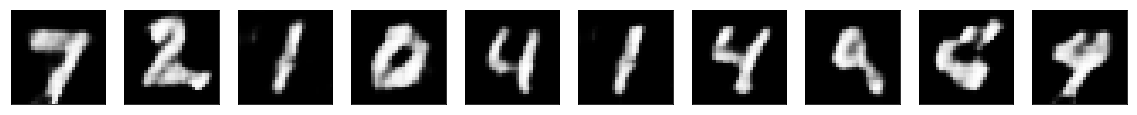

Training autoencoder 4 798
Train on 4862 samples, validate on 982 samples
Epoch 1/50
4862/4862 [==============================] - 3s 609us/step - loss: 0.4611 - val_loss: 0.2443
Epoch 2/50
4862/4862 [==============================] - 1s 122us/step - loss: 0.2397 - val_loss: 0.2324
Epoch 3/50
4862/4862 [==============================] - 1s 124us/step - loss: 0.2261 - val_loss: 0.2206
Epoch 4/50
4862/4862 [==============================] - 1s 124us/step - loss: 0.2161 - val_loss: 0.2097
Epoch 5/50
4862/4862 [==============================] - 1s 123us/step - loss: 0.2077 - val_loss: 0.1981
Epoch 6/50
4862/4862 [==============================] - 1s 124us/step - loss: 0.1983 - val_loss: 0.2184
Epoch 7/50
4862/4862 [==============================] - 1s 122us/step - loss: 0.1886 - val_loss: 0.1791
Epoch 8/50
4862/4862 [==============================] - 1s 123us/step - loss: 0.1788 - val_loss: 0.1736
Epoch 9/50
4862/4862 [==============================] - 1s 124us/step - loss: 0.1716 - val_los

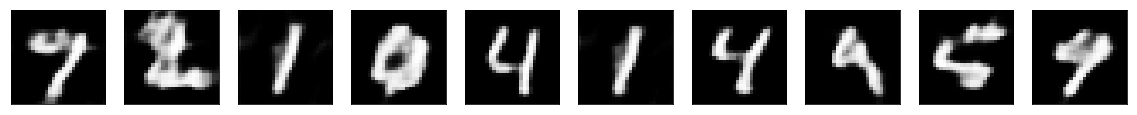

Training autoencoder 4 1024
Train on 4862 samples, validate on 982 samples
Epoch 1/50
4862/4862 [==============================] - 3s 626us/step - loss: 0.3670 - val_loss: 0.2365
Epoch 2/50
4862/4862 [==============================] - 1s 129us/step - loss: 0.2286 - val_loss: 0.2144
Epoch 3/50
4862/4862 [==============================] - 1s 133us/step - loss: 0.2106 - val_loss: 0.2016
Epoch 4/50
4862/4862 [==============================] - 1s 141us/step - loss: 0.1990 - val_loss: 0.1895
Epoch 5/50
4862/4862 [==============================] - 1s 146us/step - loss: 0.1903 - val_loss: 0.1834
Epoch 6/50
4862/4862 [==============================] - 1s 147us/step - loss: 0.1807 - val_loss: 0.1738
Epoch 7/50
4862/4862 [==============================] - 1s 144us/step - loss: 0.1745 - val_loss: 0.1700
Epoch 8/50
4862/4862 [==============================] - 1s 144us/step - loss: 0.1698 - val_loss: 0.1655
Epoch 9/50
4862/4862 [==============================] - 1s 143us/step - loss: 0.1631 - val_lo

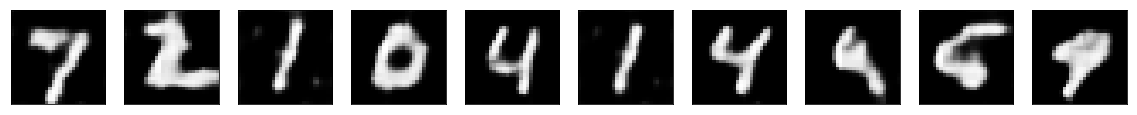

Training autoencoder 5 8
Train on 4502 samples, validate on 892 samples
Epoch 1/50
4502/4502 [==============================] - 3s 662us/step - loss: 0.6552 - val_loss: 0.5418
Epoch 2/50
4502/4502 [==============================] - 1s 113us/step - loss: 0.4319 - val_loss: 0.3664
Epoch 3/50
4502/4502 [==============================] - 0s 110us/step - loss: 0.3102 - val_loss: 0.2876
Epoch 4/50
4502/4502 [==============================] - 0s 110us/step - loss: 0.2668 - val_loss: 0.2557
Epoch 5/50
4502/4502 [==============================] - 0s 109us/step - loss: 0.2408 - val_loss: 0.2358
Epoch 6/50
4502/4502 [==============================] - 0s 110us/step - loss: 0.2268 - val_loss: 0.2190
Epoch 7/50
4502/4502 [==============================] - 1s 113us/step - loss: 0.2170 - val_loss: 0.2088
Epoch 8/50
4502/4502 [==============================] - 1s 114us/step - loss: 0.2089 - val_loss: 0.2032
Epoch 9/50
4502/4502 [==============================] - 0s 111us/step - loss: 0.2036 - val_loss:

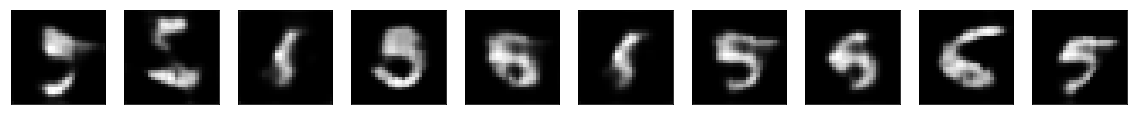

Training autoencoder 5 16
Train on 4502 samples, validate on 892 samples
Epoch 1/50
4502/4502 [==============================] - 3s 652us/step - loss: 0.6411 - val_loss: 0.5277
Epoch 2/50
4502/4502 [==============================] - 0s 108us/step - loss: 0.4283 - val_loss: 0.3574
Epoch 3/50
4502/4502 [==============================] - 0s 109us/step - loss: 0.3081 - val_loss: 0.2714
Epoch 4/50
4502/4502 [==============================] - 0s 106us/step - loss: 0.2565 - val_loss: 0.2395
Epoch 5/50
4502/4502 [==============================] - 0s 109us/step - loss: 0.2311 - val_loss: 0.2183
Epoch 6/50
4502/4502 [==============================] - 0s 108us/step - loss: 0.2165 - val_loss: 0.2087
Epoch 7/50
4502/4502 [==============================] - 0s 108us/step - loss: 0.2058 - val_loss: 0.2024
Epoch 8/50
4502/4502 [==============================] - 0s 109us/step - loss: 0.1990 - val_loss: 0.1957
Epoch 9/50
4502/4502 [==============================] - 0s 108us/step - loss: 0.1908 - val_loss

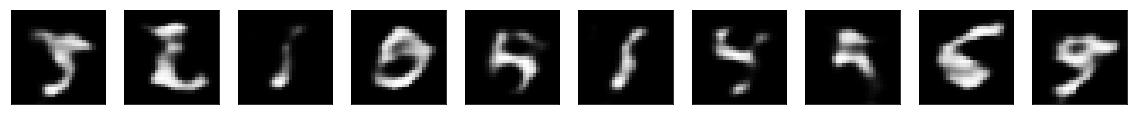

Training autoencoder 5 32
Train on 4502 samples, validate on 892 samples
Epoch 1/50
4502/4502 [==============================] - 3s 659us/step - loss: 0.5891 - val_loss: 0.3054
Epoch 2/50
4502/4502 [==============================] - 0s 110us/step - loss: 0.2790 - val_loss: 0.2650
Epoch 3/50
4502/4502 [==============================] - 0s 110us/step - loss: 0.2574 - val_loss: 0.2492
Epoch 4/50
4502/4502 [==============================] - 0s 108us/step - loss: 0.2380 - val_loss: 0.2326
Epoch 5/50
4502/4502 [==============================] - 0s 110us/step - loss: 0.2286 - val_loss: 0.2263
Epoch 6/50
4502/4502 [==============================] - 0s 109us/step - loss: 0.2192 - val_loss: 0.2130
Epoch 7/50
4502/4502 [==============================] - 0s 110us/step - loss: 0.2108 - val_loss: 0.2122
Epoch 8/50
4502/4502 [==============================] - 0s 110us/step - loss: 0.2043 - val_loss: 0.2042
Epoch 9/50
4502/4502 [==============================] - 0s 110us/step - loss: 0.1977 - val_loss

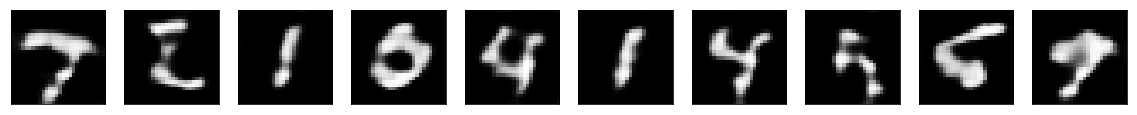

Training autoencoder 5 64


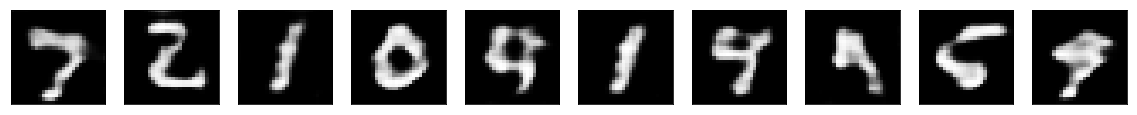

Training autoencoder 5 128


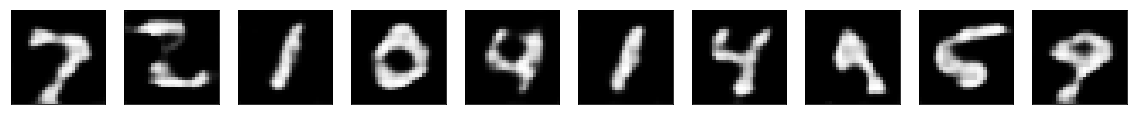

Training autoencoder 5 256


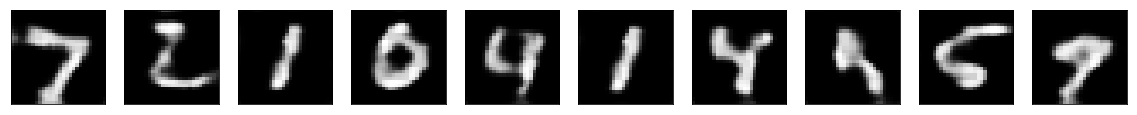

Training autoencoder 5 512
Train on 4502 samples, validate on 892 samples
Epoch 1/50
4502/4502 [==============================] - 4s 842us/step - loss: 0.4557 - val_loss: 0.2703
Epoch 2/50
4502/4502 [==============================] - 1s 121us/step - loss: 0.2607 - val_loss: 0.2485
Epoch 3/50
4502/4502 [==============================] - 1s 121us/step - loss: 0.2406 - val_loss: 0.2344
Epoch 4/50
4502/4502 [==============================] - 1s 121us/step - loss: 0.2264 - val_loss: 0.2258
Epoch 5/50
4502/4502 [==============================] - 1s 122us/step - loss: 0.2193 - val_loss: 0.2153
Epoch 6/50
4502/4502 [==============================] - 1s 125us/step - loss: 0.2110 - val_loss: 0.2049
Epoch 7/50
4502/4502 [==============================] - 1s 125us/step - loss: 0.2011 - val_loss: 0.1969
Epoch 8/50
4502/4502 [==============================] - 1s 123us/step - loss: 0.1942 - val_loss: 0.1930
Epoch 9/50
4502/4502 [==============================] - 1s 121us/step - loss: 0.1904 - val_los

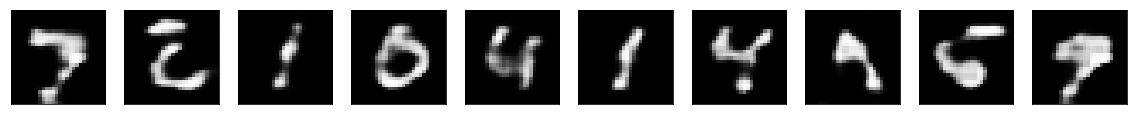

Training autoencoder 5 798
Train on 4502 samples, validate on 892 samples
Epoch 1/50
4502/4502 [==============================] - 3s 700us/step - loss: 0.4630 - val_loss: 0.2708
Epoch 2/50
4502/4502 [==============================] - 1s 125us/step - loss: 0.2524 - val_loss: 0.2392
Epoch 3/50
4502/4502 [==============================] - 1s 125us/step - loss: 0.2320 - val_loss: 0.2229
Epoch 4/50
4502/4502 [==============================] - 1s 124us/step - loss: 0.2209 - val_loss: 0.2192
Epoch 5/50
4502/4502 [==============================] - 1s 126us/step - loss: 0.2118 - val_loss: 0.2075
Epoch 6/50
4502/4502 [==============================] - 1s 128us/step - loss: 0.2025 - val_loss: 0.1938
Epoch 7/50
4502/4502 [==============================] - 1s 128us/step - loss: 0.1947 - val_loss: 0.1861
Epoch 8/50
4502/4502 [==============================] - 1s 126us/step - loss: 0.1890 - val_loss: 0.1798
Epoch 9/50
4502/4502 [==============================] - 1s 123us/step - loss: 0.1829 - val_los

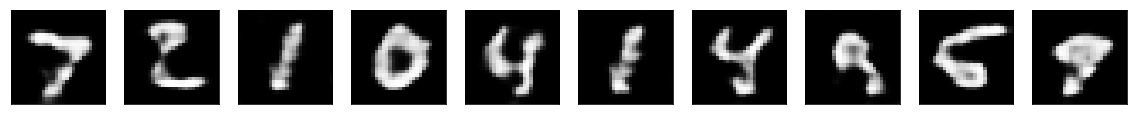

Training autoencoder 5 1024
Train on 4502 samples, validate on 892 samples
Epoch 1/50
4502/4502 [==============================] - 3s 731us/step - loss: 0.4766 - val_loss: 0.2739
Epoch 2/50
4502/4502 [==============================] - 1s 132us/step - loss: 0.2647 - val_loss: 0.2523
Epoch 3/50
4502/4502 [==============================] - 1s 131us/step - loss: 0.2434 - val_loss: 0.2369
Epoch 4/50
4502/4502 [==============================] - 1s 130us/step - loss: 0.2304 - val_loss: 0.2252
Epoch 5/50
4502/4502 [==============================] - 1s 129us/step - loss: 0.2257 - val_loss: 0.2214
Epoch 6/50
4502/4502 [==============================] - 1s 131us/step - loss: 0.2169 - val_loss: 0.2145
Epoch 7/50
4502/4502 [==============================] - 1s 129us/step - loss: 0.2116 - val_loss: 0.2067
Epoch 8/50
4502/4502 [==============================] - 1s 129us/step - loss: 0.2027 - val_loss: 0.2020
Epoch 9/50
4502/4502 [==============================] - 1s 130us/step - loss: 0.2007 - val_lo

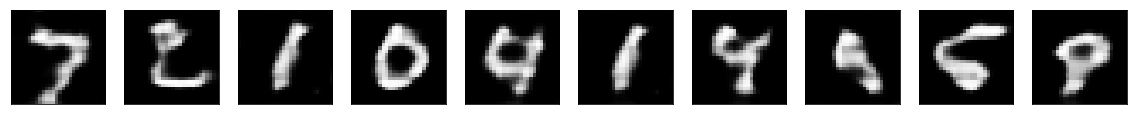

Training autoencoder 6 8
Train on 4937 samples, validate on 958 samples
Epoch 1/50
4937/4937 [==============================] - 3s 701us/step - loss: 0.5954 - val_loss: 0.3316
Epoch 2/50
4937/4937 [==============================] - 1s 109us/step - loss: 0.2624 - val_loss: 0.2427
Epoch 3/50
4937/4937 [==============================] - 1s 110us/step - loss: 0.2314 - val_loss: 0.2291
Epoch 4/50
4937/4937 [==============================] - 1s 108us/step - loss: 0.2120 - val_loss: 0.2129
Epoch 5/50
4937/4937 [==============================] - 1s 108us/step - loss: 0.2007 - val_loss: 0.2010
Epoch 6/50
4937/4937 [==============================] - 1s 107us/step - loss: 0.1911 - val_loss: 0.1874
Epoch 7/50
4937/4937 [==============================] - 1s 108us/step - loss: 0.1808 - val_loss: 0.1871
Epoch 8/50
4937/4937 [==============================] - 1s 110us/step - loss: 0.1752 - val_loss: 0.1854
Epoch 9/50
4937/4937 [==============================] - 1s 112us/step - loss: 0.1702 - val_loss:

In [ ]:
for digit in range(10):
    for n_hidden in [2, 4, 8, 16, 32, 64, 128, 256, 512, 798, 1024]:
        print("Training autoencoder", digit, n_hidden)
        autoencoder, encoder = create_model(digit, n_hidden)
        autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

        f = y_train == digit
        x_train_filtered = x_train[f]

        f = y_test == digit
        x_test_filtered = x_test[f]

        weight_file = './weights/mnist_autoencoder_digit_%d_binary_crossentropy_valsplit_%dh.hd5' % (digit, n_hidden)
        if(os.path.exists(weight_file)):
            autoencoder.load_weights(weight_file)
        else:
            autoencoder.fit(x_train_filtered, x_train_filtered,
                            epochs=50,
                            batch_size=256,
                            shuffle=True,
                            validation_data=(x_test_filtered, x_test_filtered),
                            callbacks=[])
            autoencoder.save_weights(weight_file)

        show_10_images(autoencoder.predict(x_test))